In [2]:
import pandas as pd
from io import StringIO
from bs4 import BeautifulSoup as bs
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from nltk.tokenize import word_tokenize

### Read in datasets

In [3]:
collections = pd.read_csv('collections.csv').drop(columns = ['Unnamed: 0'])
collections = collections.sort_values('designer').sort_values('seasonyear')
collections['id'] = collections.index
collections.head()

,season,year,seasonyear,designer,text,id,preprocessed_sentences,consistency,prevalence,class
0,spring,1990,1990.0,azzedine-alaia,An enfilade of stretchy knits in jewel tones w...,0,enfilad stretchi knit jewel tone effect showma...,0.235294,0.172794,2
1,spring,1990,1990.0,romeo-gigli,Romeo Gigli is having a moment. The designer’s...,1,moment design signatur cocoon shape folder stu...,0.014706,-0.985294,0
2,fall,1990,1990.1,azzedine-alaia,Alaïa worked with pinstripes and other power m...,2,work pinstrip power materi season time spot re...,0.235294,0.172794,2
3,spring,1991,1991.0,azzedine-alaia,"<a href=""https://www.vogue.com/article/bella-h...",3,hadid remind follow timeless appeal april appe...,0.235294,0.172794,2
4,spring,1991,1991.0,comme-des-garcons,"“Comme des Garçons,” Rei Kawakubo told <em>Vog...",4,told gift oneself appeal attract opposit sex s...,0.984848,0.969464,5


In [4]:
collections.shape

(14261, 10)

In [5]:
designers = pd.read_csv('designers.csv').drop(columns = ['Unnamed: 0'])
designers.head()

,designer,collections,first_season,consistency,prevalence,class
0,comme-des-garcons,65,1991.0,0.984848,0.969464,5
1,versace,61,1991.0,0.924242,0.907849,4
2,alexander-mcqueen,57,1995.0,0.982759,0.965215,5
3,prada,57,1992.0,0.890625,0.873081,4
4,miu-miu,55,1995.1,0.964912,0.946730,5


In [6]:
designers.shape

(1285, 6)

In [7]:
collections['tokens'] = [word_tokenize(sentence) for sentence in collections['preprocessed_sentences']]
sample_tokens = (collections[['id','tokens']].explode('tokens'))
sample_tokens.head()

,id,tokens
0,0,enfilad
0,0,stretchi
0,0,knit
0,0,jewel
0,0,tone


### Exploratory data analysis & visualizations

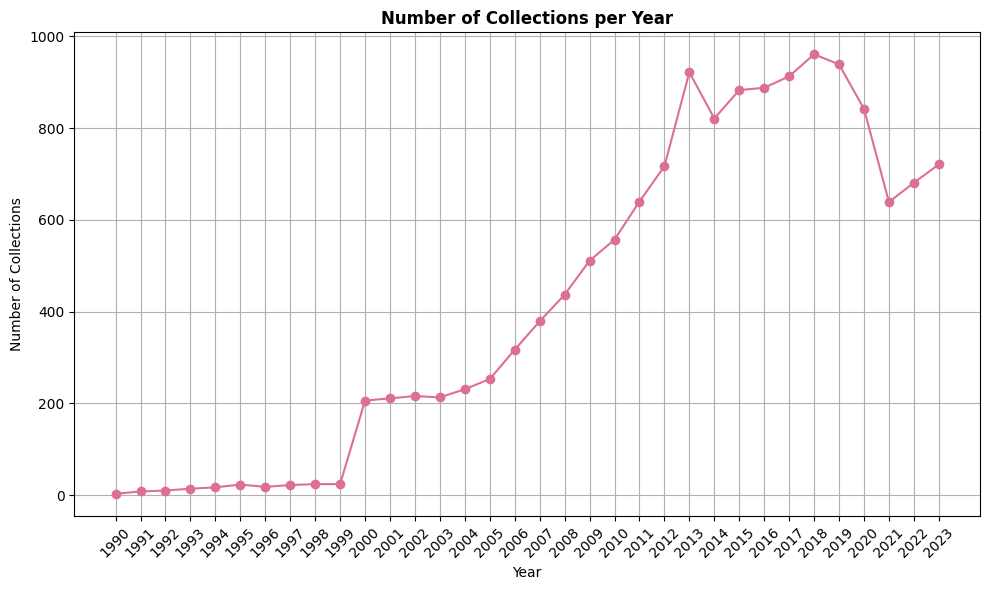

In [8]:
collections_per_year = collections.groupby(collections['year']).size()

# Plotting
plt.figure(figsize=(10, 6))
collections_per_year.plot(kind='line', marker='o', color='palevioletred')
plt.title('Number of Collections per Year', fontdict = {'fontweight':'bold'})
plt.xlabel('Year')
plt.ylabel('Number of Collections')
plt.grid(True)
plt.xticks(collections_per_year.index, rotation=45)
plt.tight_layout()
plt.show()


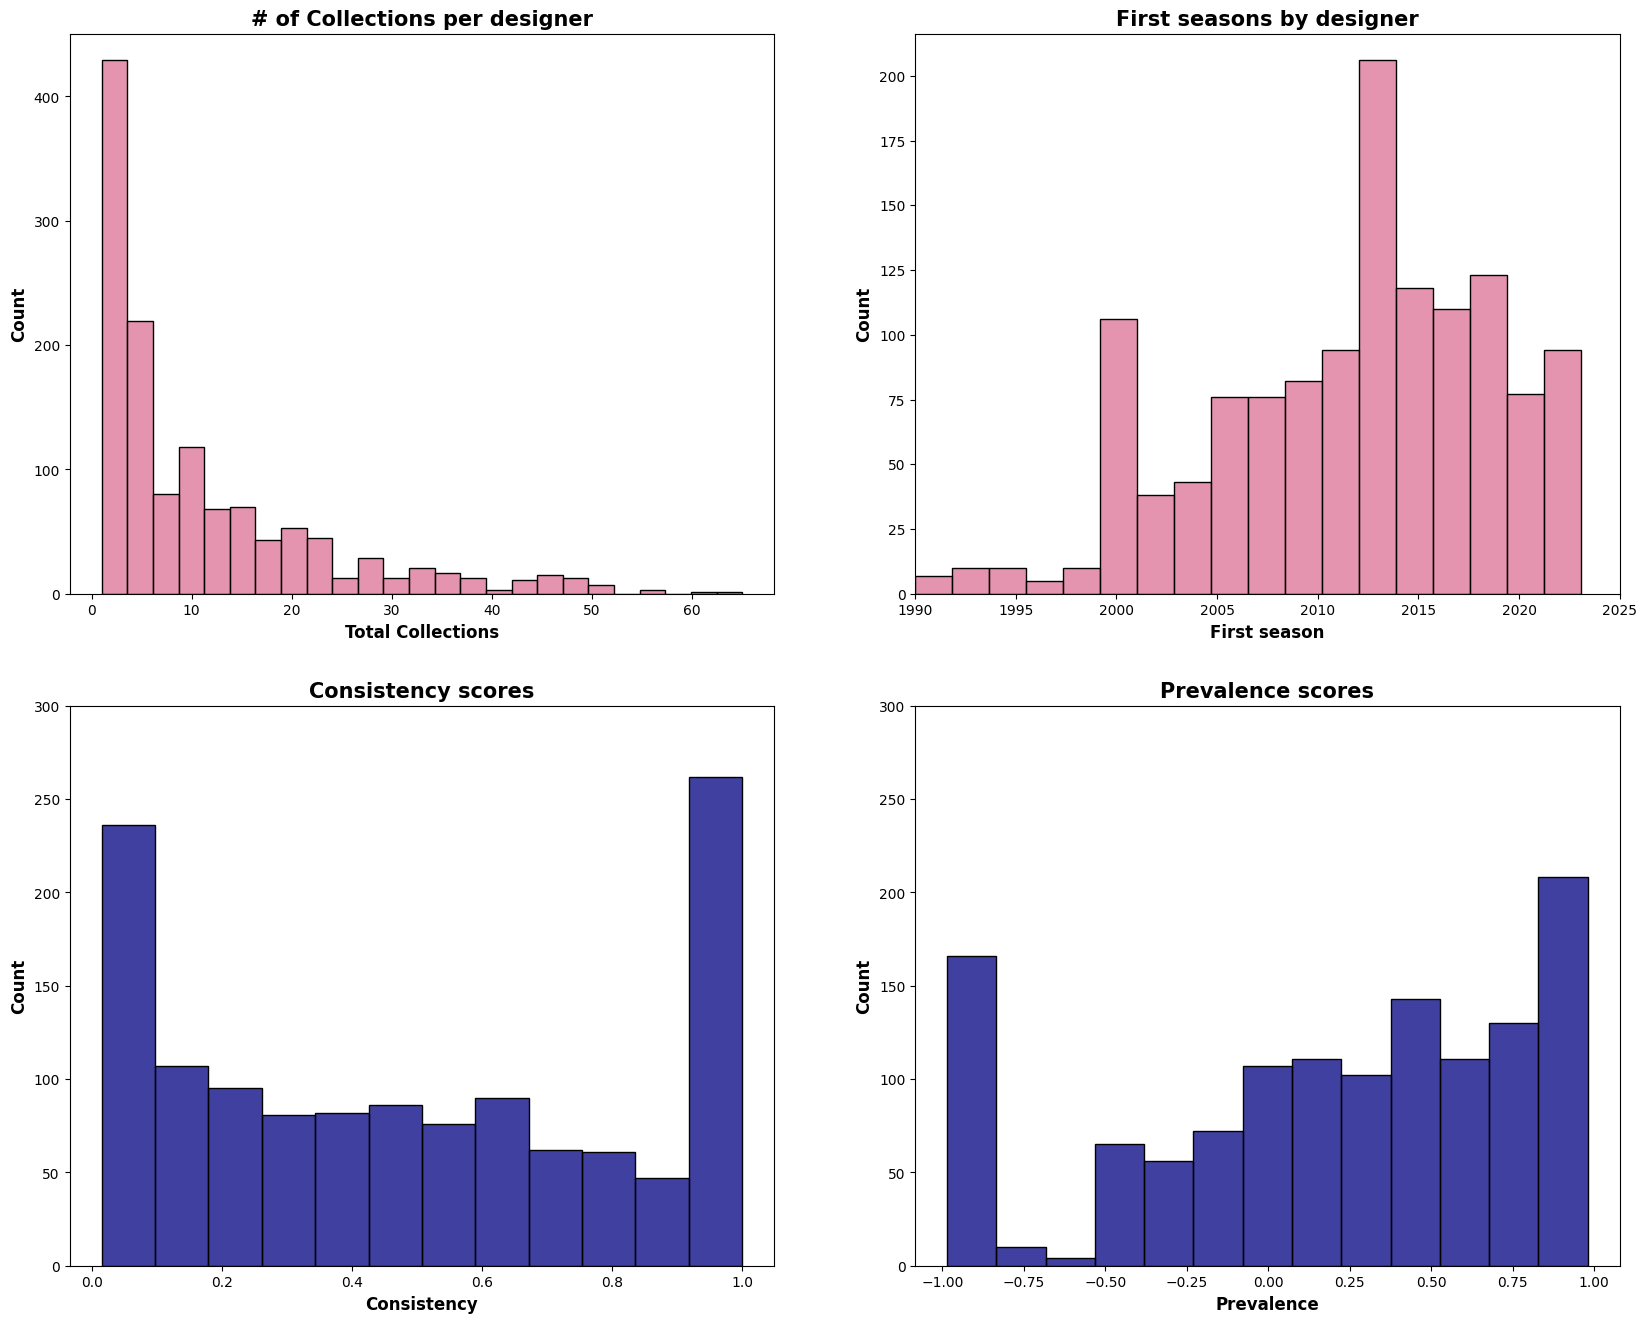

In [9]:
# plot the distributions of classes, collections, and first seasons
fig, ax = plt.subplots(2, 2, figsize=(20, 16))

# distribution of total collections
sns.histplot(data=designers,color = 'palevioletred', x = 'collections', bins="auto", ax = ax[0,0])
ax[0,0].set_title('# of Collections per designer', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[0,0].set_xlabel('Total Collections', fontsize = 12, fontweight='bold') 
ax[0,0].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# distribution of initial seasons 
sns.histplot(data=designers, color = 'palevioletred',x = 'first_season', ax = ax[0,1])
ax[0,1].set_xlim(1990,2025)
ax[0,1].set_title('First seasons by designer', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[0,1].set_xlabel('First season', fontsize = 12, fontweight='bold') 
ax[0,1].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# distribution of prevalance scores 
sns.histplot(data=designers, color = 'navy', x = 'prevalence', bins="auto", ax = ax[1,1])
ax[1,1].set_title('Prevalence scores', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[1,1].set_xlabel('Prevalence', fontsize = 12, fontweight='bold') 
ax[1,1].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# distribution of consistency scores 
sns.histplot(data=designers,color ='navy', x = 'consistency', bins="auto", ax = ax[1,0])
ax[1,0].set_title('Consistency scores', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[1,0].set_xlabel('Consistency', fontsize = 12, fontweight='bold') 
ax[1,0].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# Set the same y-axis limits for bottom two plots
ax[1,0].set_ylim(0, 300)
ax[1,1].set_ylim(0, 300)

plt.show()

In [10]:
from nltk.tokenize import word_tokenize
preprocessed = [sentence for sentence in collections['preprocessed_sentences']]
collections['tokens'] = [word_tokenize(sentence) for sentence in preprocessed]

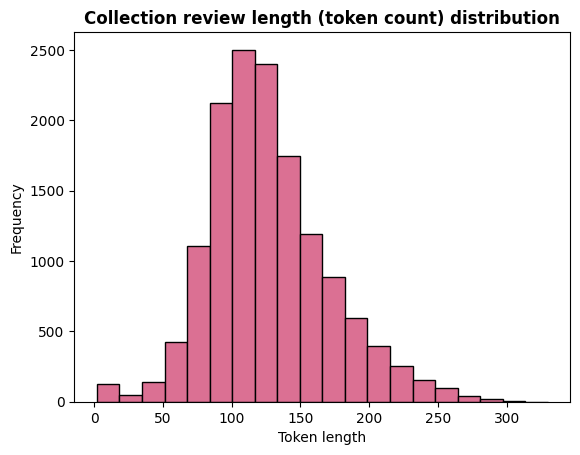

In [11]:
# plot the token length distribution using pandas
collections['length'] = collections['tokens'].apply(len)
collections['tokens'].apply(len).hist(bins=20, edgecolor = 'black', color='palevioletred')
plt.title('Collection review length (token count) distribution',fontdict = {'fontsize': 12, 'fontweight':'bold'})
plt.xlabel('Token length')
plt.grid(False)
plt.ylabel('Frequency')
plt.show()

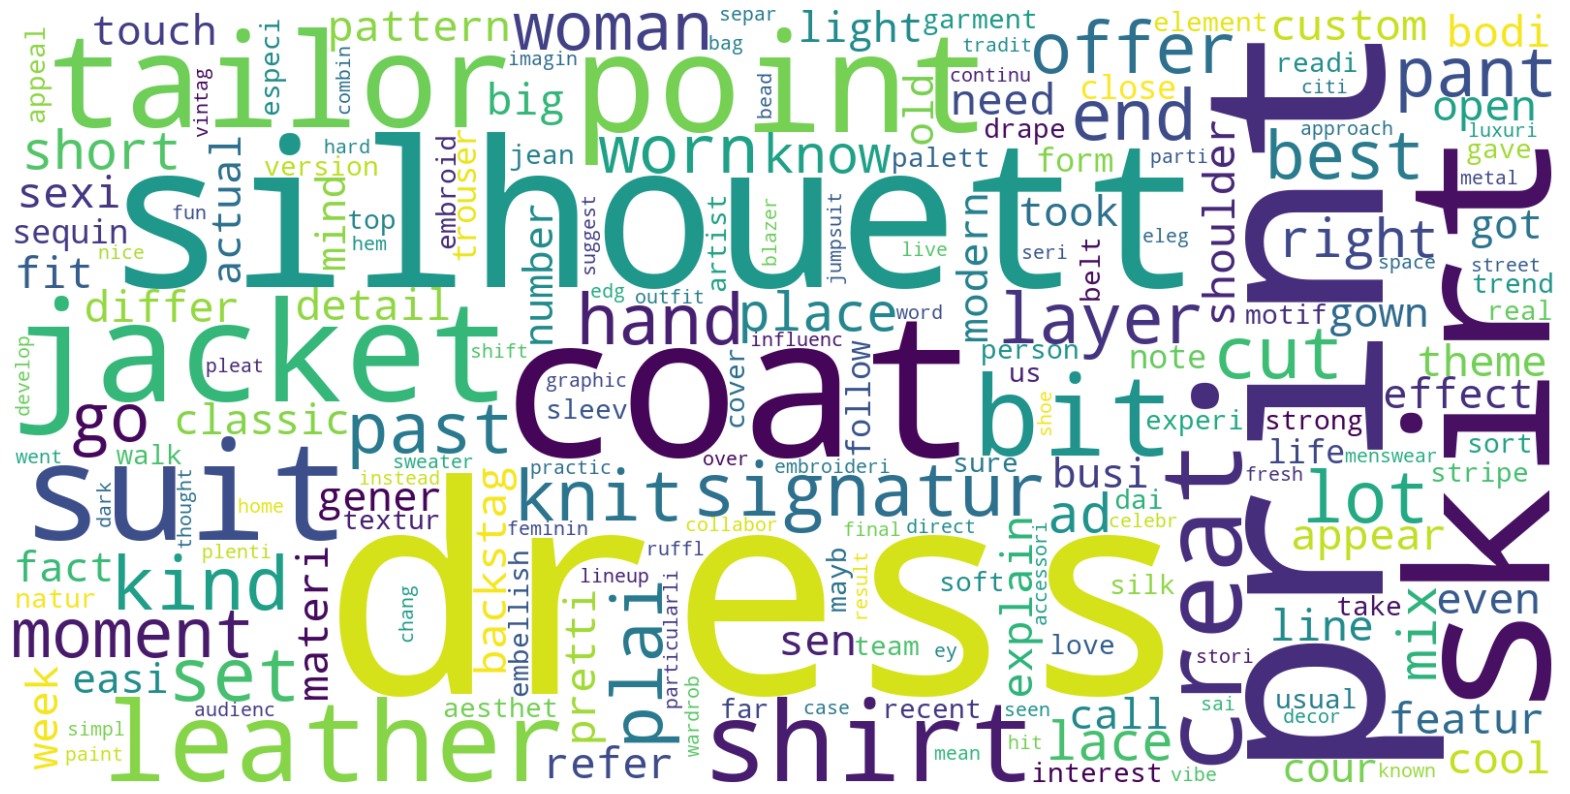

In [20]:

from wordcloud import WordCloud
stopwords = ['season','wai','good','pair','year','felt','focu','start','make', 'look','men','littl','present','fabric','girl','shape','includ', 'collect', 'show','wear','women','runwai','model', 'think','color','want','feel', 'inspir','come', 'fall','spring', 'work', 'show','like', 'todai','came','thing', 'look','design','cloth','piec','time','work','said','style','idea','turn']
wc = WordCloud(stopwords = stopwords, background_color="white", max_font_size= 300,  width=1600, height=800).generate(' '.join(sample_tokens['tokens']))

plt.figure(figsize=(20,20))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

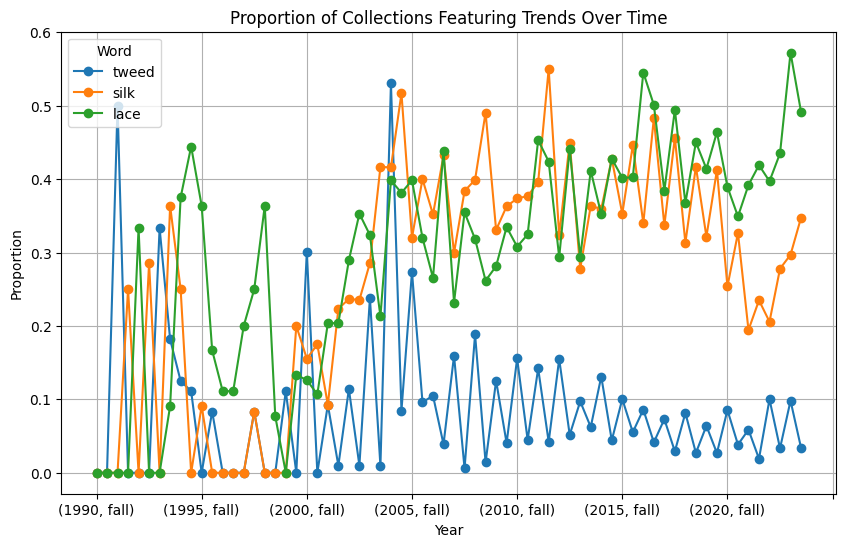

In [21]:
# analyze popularity of certain words over time

words_to_track = ['tweed', 'silk', 'lace'] 

# calculate the frequency of each word in each season or year
word_freq_over_time = collections.groupby(['year', 'season'])['preprocessed_sentences'].apply(
    lambda x: pd.Series([x.str.count(word).sum() for word in words_to_track], index=words_to_track)).unstack()

total_collections_per_season = collections.groupby(['year', 'season'])['id'].count()

# Calculate the proportion of collections containing each word for each season or year
word_prop_over_time = word_freq_over_time.div(total_collections_per_season, axis=0)

word_prop_over_time.plot(kind='line', marker='o', figsize=(10, 6))
plt.title('Proportion of Collections Featuring Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Proportion')
plt.legend(title='Word')
plt.grid(True)
plt.show()

In [19]:
subset = collections[collections['year']>=1990].copy()
subset = subset[subset['year']<=1995]
subset_tokens = (subset[['id','tokens']].explode('tokens'))
sample_tokens['tokens'].value_counts()[70:100]

tokens
plai        2645
lot         2612
make        2600
bit         2589
creat       2575
kind        2542
line        2526
top         2507
stripe      2494
signatur    2462
floral      2459
sweater     2444
right       2415
sens        2389
pattern     2379
pleat       2377
even        2360
best        2347
end         2344
woman       2342
pink        2326
past        2319
week        2294
offer       2293
fit         2250
big         2224
theme       2200
open        2171
differ      2165
mix         2164
Name: count, dtype: int64

### TF-IDF Analysis

In [66]:
# create a word frequency dataframe
term_frequency = (sample_tokens
                  .groupby(by=['id', 'tokens'])
                  .agg({'tokens': 'count'})
                  .rename(columns={'tokens': 'term_frequency'})
                  .reset_index()
                  .rename(columns={'tokens': 'term'})
                 )

term_frequency.sort_values('term_frequency', ascending = False)[25:40]

,id,term,term_frequency
1411946,12838,monogram,10
1606517,14207,hors,10
721509,7460,wool,10
1612399,14247,alien,10
1547315,13798,merhej,10
1587192,14070,heart,10
889132,8855,look,10
1114134,10619,dough,10
1053990,10146,like,10
1558832,13880,embroid,10


In [67]:
# Document Frequency
document_frequency = (term_frequency
                      .groupby(['id', 'term'])
                      .size()
                      .unstack()
                      .sum()
                      .reset_index()
                      .rename(columns={0: 'document_frequency'})
                     )

# merge dataframes
term_frequency = term_frequency.merge(document_frequency)

documents_in_corpus = term_frequency['id'].nunique()

term_frequency['idf'] = np.log((1 + documents_in_corpus) / (1 + term_frequency['document_frequency'])) + 1
term_frequency['tfidf'] = term_frequency['term_frequency'] * term_frequency['idf']

In [68]:
from sklearn import preprocessing
term_frequency['tfidf_norm'] = preprocessing.normalize(term_frequency[['tfidf']], axis=0, norm='l2')
term_frequency.sort_values(by=['tfidf_norm'], ascending=[False]).groupby(['term']).head()

,id,term,term_frequency,document_frequency,idf,tfidf,tfidf_norm
1613977,14031,abijako,14,1.0,9.872207,138.210895,0.020064
639426,7076,review,19,179.0,5.372397,102.075545,0.014818
1611773,13296,linnetz,11,5.0,8.773594,96.509539,0.014010
1606861,10619,dough,10,2.0,9.466742,94.667416,0.013743
1612745,13283,yadda,9,1.0,9.872207,88.849861,0.012898
...,...,...,...,...,...,...,...
1424557,718,conjur,1,347.0,4.713151,4.713151,0.000684
461713,242,accessor,1,357.0,4.684821,4.684821,0.000680
461715,334,accessor,1,357.0,4.684821,4.684821,0.000680
956397,6406,strongest,1,363.0,4.668200,4.668200,0.000678


### Fitting a Naive Bayes classifier to evaluate word significance and predict class of designer based on collection description
Using the collections dataframe, we use a supervised learning algorithm to classify the designer collections.

In [69]:
# check for seasons that only have one datapoint

collections['designer'].value_counts()

designer
comme-des-garcons    65
versace              61
prada                57
alexander-mcqueen    57
miu-miu              55
                     ..
joy-cioci             1
jayson-brunsdon       1
lala-berlin           1
laurel                1
marco-rambaldi        1
Name: count, Length: 1285, dtype: int64

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import word_tokenize, WhitespaceTokenizer, TweetTokenizer

subset = collections[collections['seasonyear']>1990.1]

X = subset['preprocessed_sentences']
y = subset['season']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y)

In [75]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_test_le = label_encoder.transform(y_test)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_test_le.shape}')

Label encoded training labels shape: (10693,)
Label encoded validation labels shape: (3565,)


In [76]:
# Naive Bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
X_train = cv.fit_transform(X_train.values)
X_test = cv.transform(X_test.values)

nb_model =  MultinomialNB()
nb_model.fit(X_train, y_train_le)

# Predict the authors of validation dataset
nb_predictions = nb_model.predict(X_test)

print(nb_model.score(X_test, y_test_le))

0.8311360448807854


### SVC (Baseline model)
Predicting the class (prevalence score) of a designer based on their collection description.

In [22]:
# Separate features and target
X = collections['preprocessed_sentences']
y = collections['season']

In [23]:
from sklearn.model_selection import train_test_split
train_ratio = 0.7
validation_ratio = 0.2
test_ratio = 0.1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio, random_state=42, stratify = y)

X_val, x_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), stratify = y_test, random_state=42)

print(f'Training samples: {len(X_train)}')
print(f'Validation samples: {len(X_val)}')

Training samples: 9982
Validation samples: 2852


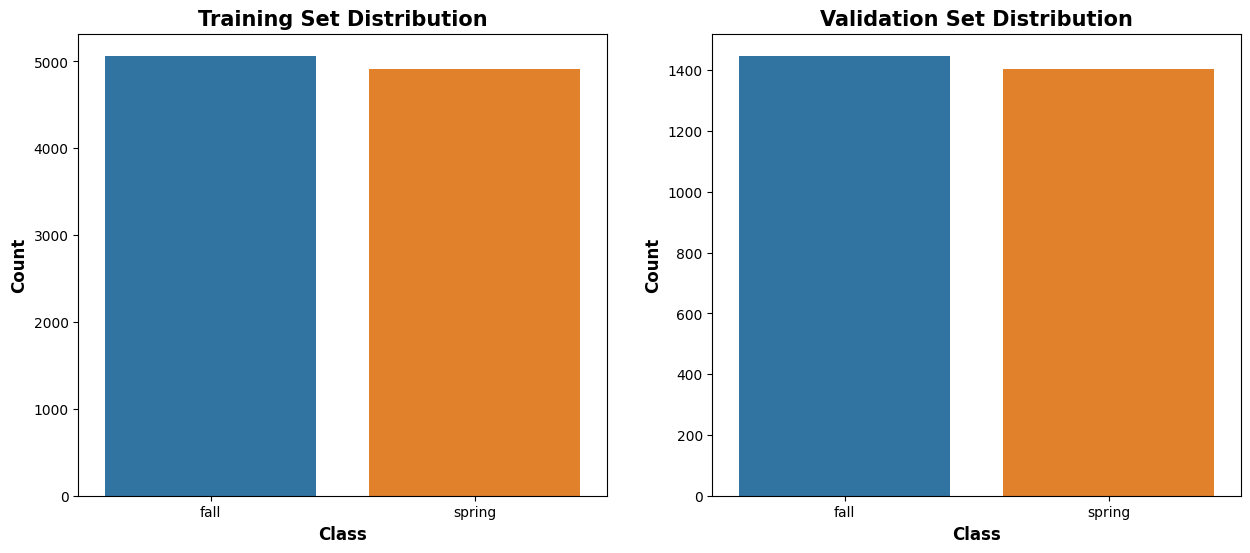

In [24]:
# plot the distribution of the target classes in the training and validation set on a countplot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# first plot is the training set
sns.countplot(data = y_train.to_frame(name = 'Class').sort_values('Class'), x = 'Class',ax=ax[0])
ax[0].set_title('Training Set Distribution', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[0].set_xlabel('Class', fontsize = 12, fontweight='bold') 
ax[0].set_ylabel('Count', fontsize = 12, fontweight='bold') 

# second plot is the validation set

sns.countplot(data = y_val.to_frame(name = 'Class').sort_values('Class'), x = 'Class', ax=ax[1])
ax[1].set_title('Validation Set Distribution', fontdict = {'fontsize': 15, 'fontweight':'bold'})
ax[1].set_xlabel('Class', fontsize = 12, fontweight='bold') 
ax[1].set_ylabel('Count', fontsize = 12, fontweight='bold') 
plt.show()

In [25]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse_output=False)

y_train_ohe = ohe.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_ohe = ohe.fit_transform(np.array(y_val).reshape(-1, 1))

print(f'One hot encoded training labels shape: {y_train_ohe.shape}')
print(f'One hot encoded validation labels shape: {y_val_ohe.shape}')

One hot encoded training labels shape: (9982, 2)
One hot encoded validation labels shape: (2852, 2)


In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_le = label_encoder.fit_transform(y_train)
y_val_le = label_encoder.fit_transform(y_val)

print(f'Label encoded training labels shape: {y_train_le.shape}')
print(f'Label encoded validation labels shape: {y_val_le.shape}')

Label encoded training labels shape: (9982,)
Label encoded validation labels shape: (2852,)


In [27]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
import time

In [28]:
start_time = time.time()
text_clf = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
    ('clf', SVC(kernel='rbf', C = 1.51, random_state=42))
])
# fit the model
text_clf.fit(X_train, y_train_le)
end_time = time.time()  # Record the end time
execution_time = end_time - start_time  # Calculate execution time
print("Execution time:", execution_time, "seconds")

Execution time: 581.1311118602753 seconds


In [29]:
text_clf.score(X_val, y_val_le)

0.8727208976157083

In [30]:
y_pred = text_clf.predict(X_val)
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_val_le, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.88      1448
           1       0.88      0.86      0.87      1404

    accuracy                           0.87      2852
   macro avg       0.87      0.87      0.87      2852
weighted avg       0.87      0.87      0.87      2852



### Recurrent Neural Network


In [104]:
# Count unique tokens
unique_tokens = set(list(sample_tokens['tokens']))
num_unique_tokens = len(unique_tokens)
from collections import Counter

print('Total vocab size:', len(Counter(sample_tokens['tokens'])))
collections['length'].describe()


Total vocab size: 32558


count    14261.000000
mean       126.715798
std         43.550884
min          2.000000
25%         98.000000
50%        121.000000
75%        150.000000
max        330.000000
Name: length, dtype: float64

In [107]:
import tensorflow as tf

In [108]:
from tensorflow.keras.layers import TextVectorization

# YOUR CODE HERE - Create a TextVectorization layer - what arguments will you use? Explain your choice of arguments.
text_vectorizer = TextVectorization(max_tokens= 32558, output_sequence_length= 150)

In [113]:
# Adapt the text vectorizer to the training data
text_vectorizer.adapt(X_train)

In [115]:
# examine the vocabulary
vocab = text_vectorizer.get_vocabulary()
print(f'Number of words in the vocabulary: {len(vocab)}')
print(f'Most common words in the vocabulary: {vocab[:5]}')
print(f'Least common words in the vocabulary: {vocab[-5:]}')

Number of words in the vocabulary: 28701
Most common words in the vocabulary: ['', '[UNK]', 'look', 'like', 'dress']
Least common words in the vocabulary: ['aamion', 'aalto', 'aaaargh', 'aaaaahhhhh', 'aaaaag']


In [119]:
token_embedding = tf.keras.layers.Embedding(input_dim=len(vocab),
                                            output_dim=128,
                                            mask_zero=True,
                                            name='token_embedding')

# Randomly visualize some of your vectorized textual data
import random
example_sent = random.choice(X_train.values) # change var name if you need to
print(f'Sentence before vectorization: {example_sent}')
vectorized_sent = text_vectorizer(example_sent)
print(f'Sentence after vectorization: {vectorized_sent}')
embedded_sent = token_embedding(vectorized_sent)
print(f'Sentence after embedding: {embedded_sent}')

Sentence before vectorization: held high ninth avenu probabl altitudin week aeri like space present showcas eagl ey precis tailor strong silhouett driven vision fall look doubl breast jacket stripe shirt boi pant borderlin preppi look jacket crop shoulder broaden pant pleat reapproach classic recut reproport said backstag render entir shape balanc cloth mention tough wedg winkl pickeri boot referenc menswear year japanes took shroud challeng classic line mix wool felt camel hair napa leather flannel cut coat jacket substanti cashmer sweater number silk piec success black white print look like easi shirt drape skirt dress stud look lost rest describ soundtrack industri rigid militari continu path troubl find conscript
Sentence after vectorization: [  665    46  9433  1390   555 28487    94 28614     3   208    48  1106
  5772   139   548    44   164    47  1830   382    20     2   162   544
     9    80    35   606    22  5796  1769     2     9   123    56  3718
    22    86 16721   134

In [121]:
X_dataset = tf.data.Dataset.from_tensor_slices((X_train.values, y_train_le))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val.values, y_val_le))

In [124]:
for sample in X_dataset.take(3):
    review, label = sample
    print(f'Review: {review} - Label: {label}')

Review: b'aim independ woman negoti wai jungl contemporari life terrif spring design took idea liter show rang cloth come closet sexi amazon windblown gleam iridesc bronzer model stalk runwai gorgeou nutti leather cut variat bomber motorcycl style worn copperi silk jersei piec stitch leather belt big doubl miniskirt model silk jersei favorit fabric asymmetr fit dress charm ruch retro swim return later pair skirt even desert tone peachi terra cotta paperi pale green karan versatil savag look switch effortlessli cityfi sophist fit jacket crinkli viscos tobacco color silk tweed suit slim coat love ivori blous deep ruffl collar accent artisan feminin detail like littl drawstr pocket pintuck frai grosgrain ribbon close seri ether dress gown scatter oxid sequin woven band flutter shred chiffon vibrant sensuou wearabl celebratori close chapter week' - Label: 3
Review: b'month second septemb tonight collect head demna gvasalia semifinalist second annual lvmh prize contest thought recognit gvas

2024-05-11 23:26:30.875937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [125]:
BATCH_SIZE = 32
BUFFER_SIZE = 10_000

In [126]:
train_dataset = X_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [140]:
# MODEL Hyperparameters
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss = 'sparse_categorical_crossentropy'
epochs = 10

In [145]:
# Model architecture
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import TextVectorization, Bidirectional, LSTM, Dropout, Dense

inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)

x = tf.keras.layers.Embedding(input_dim=len(vocab), output_dim=128, mask_zero=True)(x)
x = Dropout(0.5)(x)
x = tf.keras.layers.LSTM(100)(x)
x = Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)  # Additional Dense layer
x = Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)

outputs = layers.Dense(len(collections['class'].unique()), activation='softmax')(x)

# model creation
model = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [146]:
# Train the model or fit the model on the data
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)

Epoch 1/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 66s 206ms/step - accuracy: 0.2263 - loss: 1.7565 - val_accuracy: 0.2781 - val_loss: 1.5935
Epoch 2/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 40s 129ms/step - accuracy: 0.2586 - loss: 1.6355 - val_accuracy: 0.2872 - val_loss: 1.5782
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.2664 - loss: 1.5973 - val_accuracy: 0.3029 - val_loss: 1.5538
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.2700 - loss: 1.5425 - val_accuracy: 0.3121 - val_loss: 1.5383
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.2880 - loss: 1.4840 - val_accuracy: 0.3201 - val_loss: 1.5347
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 125ms/step - accuracy: 0.3139 - loss: 1.4315 - val_accuracy: 0.3271 - val_loss: 1.5333
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 124ms/step - accuracy: 0.3671 - loss: 1.3767 - val_accuracy: 0.3201 - val_loss: 1.5454
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 127ms/step - accuracy: 0.4054 - loss: 1

In [134]:
# plot the training history
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

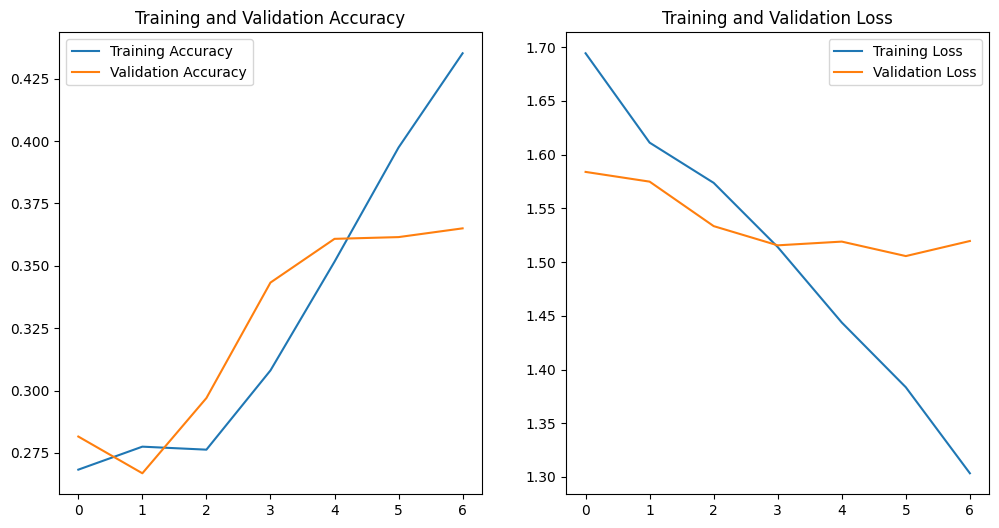

In [132]:
plot_history(history)

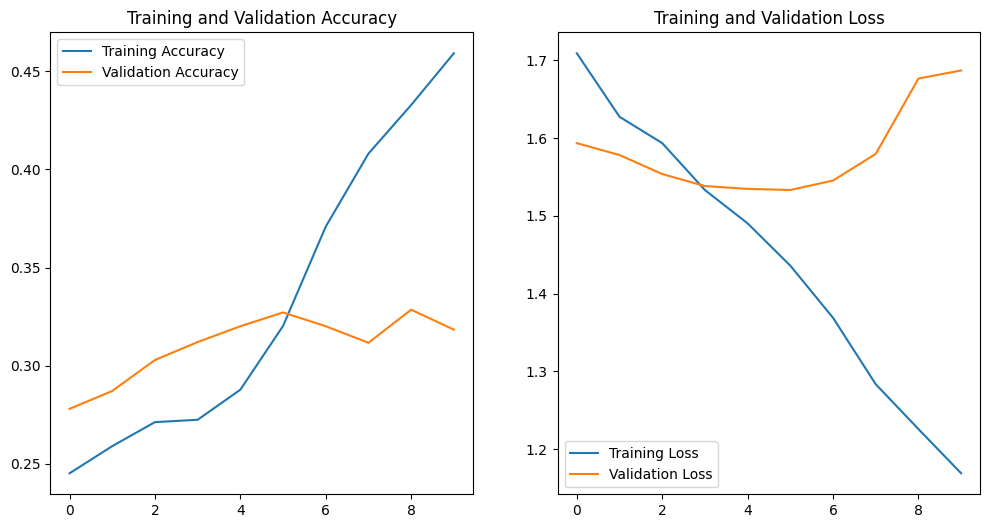

In [147]:
plot_history(history)